In [1]:
# RUN THIS LINE ONLY ONCE !!!
import sys
import os
os.chdir('../')
sys.path.append(os.getcwd())

In [2]:
from utils import get_dataset, validate
from learner import Learner
from schedulers import CyclicLRDecay
import random
import torch
import torch.nn as nn
from torch.optim import AdamW
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# If you have dark theme
from matplotlib.pyplot import rcParams
rcParams['figure.facecolor'] = 'white'

In [4]:
# Setup logger
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s : %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

In [5]:
dataset, emb_weights = get_dataset()
dataset.fields['review'].include_lengths = True

random.seed(43)
ds_train, ds_val, ds_test = dataset.split(split_ratio=[0.8, 0.1, 0.1], random_state=random.getstate())

06/01/2020 11:23:50 PM INFO : Downloading data
06/01/2020 11:23:52 PM INFO : Downloading GloVe word vectors
06/01/2020 11:23:52 PM INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt
06/01/2020 11:24:01 PM INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt


<br>

### Gru with head attached to the last hidden state

In [6]:
class GRUmodel(nn.Module):
    def __init__(self, embed_vecs=None, hidden_size=16,
                 num_layers=1, dropout=(0,0), bidirectional=False):
        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(embed_vecs)

        self.dropout = nn.Dropout(p=dropout[1])
        self.gru = nn.GRU(input_size=emb_weights.size()[1], hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout[0],
                          bidirectional=bidirectional, batch_first=True)
        self.head = nn.Linear(self.num_directions*self.hidden_size, 2)

        
    def forward(self, batch):
        batch, lengths = batch
        batch_dim, _ = batch.shape
        
        embedded = self.dropout(self.embedding(batch))
        embedded_packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            lengths,
            batch_first=True,
            enforce_sorted=False
        )
        
        outputs_packed, hiddens = self.gru(embedded_packed)
        
        last_hidden = hiddens.view(self.num_layers, self.num_directions,
                                   batch_dim, self.hidden_size)[-1]
        hidden_concat = last_hidden.transpose(1,0).reshape(
            batch_dim, self.num_directions*self.hidden_size
        )
        
        logging.debug('batch shape : {}'.format(batch.shape))
        logging.debug('embedding shape : {}'.format(embedded.shape))
        logging.debug('hiddens shape : {}'.format(hiddens.shape))
        logging.debug('hidden_concat shape : {}'.format(hidden_concat.shape))
        
        return self.head(self.dropout(hidden_concat))

In [7]:
model = GRUmodel(emb_weights.clone(), num_layers=1, hidden_size=32,
                 bidirectional=True, dropout=(0, 0.5)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)
cycle_steps = 2*(len(ds_train)//32 + 1)
scheduler = CyclicLRDecay(optimiser, 1e-4, 1e-2, cycle_steps, 0.25, gamma_factor=0.65)
learner = Learner(model, loss_fn, optimiser, scheduler, ds_train, ds_val, device)

1.00%1.00%

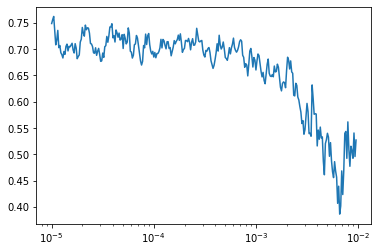

In [8]:
learner.lr_finder(bs=32, lr_range=(1e-5, 1e-2))

In [9]:
learner.train(epochs=8, bs=32, grad_clip=(0.1, 2.2))

06/01/2020 11:25:35 PM INFO : Epoch : 1, batch : 18, train_loss = 0.7132, val_loss = 0.6701, val_accuracy : 0.547, time = 1s
06/01/2020 11:25:35 PM INFO : Epoch : 1, batch : 36, train_loss = 0.6662, val_loss = 0.5888, val_accuracy : 0.687, time = 1s
06/01/2020 11:25:36 PM INFO : Epoch : 1, batch : 54, train_loss = 0.5827, val_loss = 0.4839, val_accuracy : 0.797, time = 2s
06/01/2020 11:25:36 PM INFO : Epoch : 1, batch : 72, train_loss = 0.4982, val_loss = 0.4764, val_accuracy : 0.810, time = 2s
06/01/2020 11:25:37 PM INFO : Epoch : 2, batch : 18, train_loss = 0.4484, val_loss = 0.3799, val_accuracy : 0.843, time = 3s
06/01/2020 11:25:38 PM INFO : Epoch : 2, batch : 36, train_loss = 0.4169, val_loss = 0.3489, val_accuracy : 0.847, time = 4s
06/01/2020 11:25:39 PM INFO : Epoch : 2, batch : 54, train_loss = 0.3874, val_loss = 0.3294, val_accuracy : 0.863, time = 5s
06/01/2020 11:25:39 PM INFO : Epoch : 2, batch : 72, train_loss = 0.4288, val_loss = 0.3219, val_accuracy : 0.863, time = 6s


In [10]:
model.embedding.weight.requires_grad_(True);
learner.train(epochs=4, bs=32, grad_clip=(0.1, 1.2))

06/01/2020 11:25:59 PM INFO : Epoch : 1, batch : 18, train_loss = 0.2732, val_loss = 0.2811, val_accuracy : 0.887, time = 2s
06/01/2020 11:26:01 PM INFO : Epoch : 1, batch : 36, train_loss = 0.2570, val_loss = 0.2771, val_accuracy : 0.883, time = 3s
06/01/2020 11:26:02 PM INFO : Epoch : 1, batch : 54, train_loss = 0.2496, val_loss = 0.2802, val_accuracy : 0.890, time = 5s
06/01/2020 11:26:04 PM INFO : Epoch : 1, batch : 72, train_loss = 0.2308, val_loss = 0.2744, val_accuracy : 0.883, time = 6s
06/01/2020 11:26:05 PM INFO : Epoch : 2, batch : 18, train_loss = 0.1807, val_loss = 0.2805, val_accuracy : 0.880, time = 8s
06/01/2020 11:26:07 PM INFO : Epoch : 2, batch : 36, train_loss = 0.1822, val_loss = 0.2795, val_accuracy : 0.893, time = 9s
06/01/2020 11:26:08 PM INFO : Epoch : 2, batch : 54, train_loss = 0.1914, val_loss = 0.2797, val_accuracy : 0.887, time = 10s
06/01/2020 11:26:09 PM INFO : Epoch : 2, batch : 72, train_loss = 0.2322, val_loss = 0.2741, val_accuracy : 0.893, time = 12

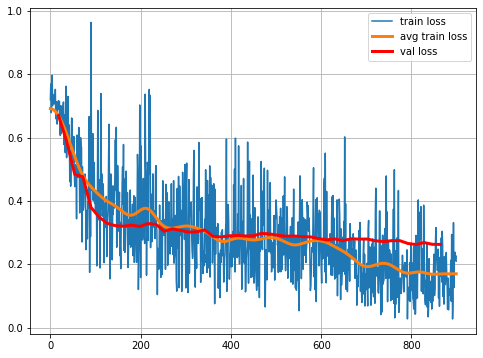

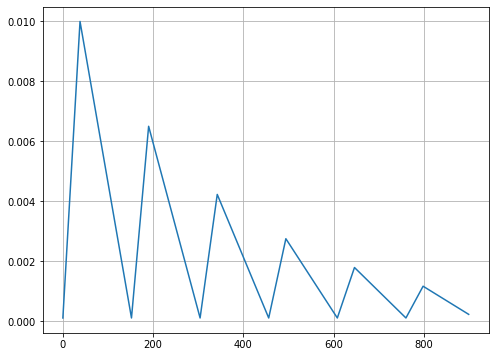

In [11]:
learner.recorder.plot_losses(show_lr=True)

In [12]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(ds_test, loss_fn, model)))

Test loss : 0.26543, test accuracy : 0.907


<br>

### Add concat pooling layer

In [13]:
class GRUmodel(nn.Module):
    def __init__(self, embed_vecs=None, hidden_size=512,
                 num_layers=1, dropout=(0, 0), bidirectional=False):
        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(embed_vecs)

        self.gru = nn.GRU(input_size=emb_weights.size()[1], hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout[0],
                          bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(p=dropout[1])
        self.head = nn.Linear(3*self.num_directions*self.hidden_size, 2)

        
    def forward(self, batch):
        batch, lengths = batch
        batch_dim, _ = batch.shape
        
        embedded = self.dropout(self.embedding(batch))
        embedded_packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        outputs_packed, hiddens = self.gru(embedded_packed)
        outputs, lengths = nn.utils.rnn.pad_packed_sequence(outputs_packed, batch_first=True)
        
        last_hidden = hiddens.view(self.num_layers, self.num_directions, batch_dim, self.hidden_size)[-1,:,:,:]
        hidden_concat = last_hidden.transpose(1,0).reshape(batch_dim, self.num_directions*self.hidden_size)
        
        avg_pool = torch.sum(outputs, dim=1)/lengths.unsqueeze(1)
        max_pool = torch.cat([sample[:length].max(dim=0)[0].unsqueeze(0) for sample, length in zip(outputs, lengths)], dim=0)
        
        logging.debug('batch shape : {}'.format(batch.shape))
        logging.debug('embedding shape : {}'.format(embedded.shape))
        logging.debug('hiddens shape : {}'.format(hiddens.shape))
        logging.debug('outputs shape : {}'.format(outputs.shape))
        logging.debug('avg_pool shape : {}'.format(avg_pool.shape))
        logging.debug('max_pool shape : {}'.format(max_pool.shape))
        logging.debug('hidden_concat shape : {}'.format(hidden_concat.shape))
        
        return self.head(self.dropout(torch.cat([hidden_concat, avg_pool, max_pool], dim=1)))

In [14]:
model = GRUmodel(emb_weights.clone(), num_layers=1, hidden_size=32,
                 bidirectional=True, dropout=(0, 0.5)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = AdamW(model.parameters(), weight_decay=2e-3)
cycle_steps = 2*(len(ds_train)//32 + 1)
scheduler = CyclicLRDecay(optimiser, 1e-4, 1e-2, cycle_steps, 0.25, gamma_factor=0.65)
learner = Learner(model, loss_fn, optimiser, scheduler, ds_train, ds_val, device)

1.00%1.00%

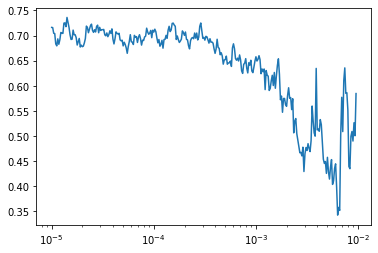

In [15]:
learner.lr_finder(bs=32, lr_range=(1e-5, 1e-2))

In [16]:
learner.train(epochs=8, bs=32, grad_clip=(0.1, 1.2))

06/01/2020 11:29:29 PM INFO : Epoch : 1, batch : 18, train_loss = 0.7072, val_loss = 0.6346, val_accuracy : 0.690, time = 1s
06/01/2020 11:29:30 PM INFO : Epoch : 1, batch : 36, train_loss = 0.5955, val_loss = 0.5199, val_accuracy : 0.777, time = 2s
06/01/2020 11:29:31 PM INFO : Epoch : 1, batch : 54, train_loss = 0.5585, val_loss = 0.4404, val_accuracy : 0.823, time = 3s
06/01/2020 11:29:32 PM INFO : Epoch : 1, batch : 72, train_loss = 0.4866, val_loss = 0.4537, val_accuracy : 0.823, time = 4s
06/01/2020 11:29:33 PM INFO : Epoch : 2, batch : 18, train_loss = 0.4317, val_loss = 0.3711, val_accuracy : 0.847, time = 5s
06/01/2020 11:29:34 PM INFO : Epoch : 2, batch : 36, train_loss = 0.4014, val_loss = 0.3595, val_accuracy : 0.857, time = 6s
06/01/2020 11:29:35 PM INFO : Epoch : 2, batch : 54, train_loss = 0.4038, val_loss = 0.3486, val_accuracy : 0.857, time = 7s
06/01/2020 11:29:36 PM INFO : Epoch : 2, batch : 72, train_loss = 0.4276, val_loss = 0.3424, val_accuracy : 0.870, time = 8s


In [17]:
model.embedding.weight.requires_grad_(True);
learner.train(epochs=4, bs=32, grad_clip=(0.1, 1.2))

06/01/2020 11:30:00 PM INFO : Epoch : 1, batch : 18, train_loss = 0.2624, val_loss = 0.2795, val_accuracy : 0.880, time = 2s
06/01/2020 11:30:01 PM INFO : Epoch : 1, batch : 36, train_loss = 0.2689, val_loss = 0.2770, val_accuracy : 0.890, time = 3s
06/01/2020 11:30:03 PM INFO : Epoch : 1, batch : 54, train_loss = 0.2856, val_loss = 0.2785, val_accuracy : 0.880, time = 5s
06/01/2020 11:30:05 PM INFO : Epoch : 1, batch : 72, train_loss = 0.2805, val_loss = 0.2787, val_accuracy : 0.870, time = 6s
06/01/2020 11:30:06 PM INFO : Epoch : 2, batch : 18, train_loss = 0.1797, val_loss = 0.2750, val_accuracy : 0.877, time = 8s
06/01/2020 11:30:08 PM INFO : Epoch : 2, batch : 36, train_loss = 0.2052, val_loss = 0.2737, val_accuracy : 0.883, time = 10s
06/01/2020 11:30:09 PM INFO : Epoch : 2, batch : 54, train_loss = 0.2041, val_loss = 0.2732, val_accuracy : 0.870, time = 11s
06/01/2020 11:30:11 PM INFO : Epoch : 2, batch : 72, train_loss = 0.2324, val_loss = 0.2715, val_accuracy : 0.880, time = 1

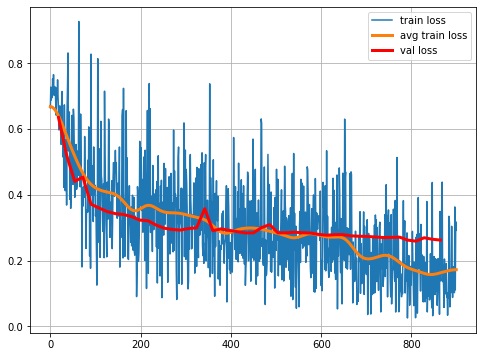

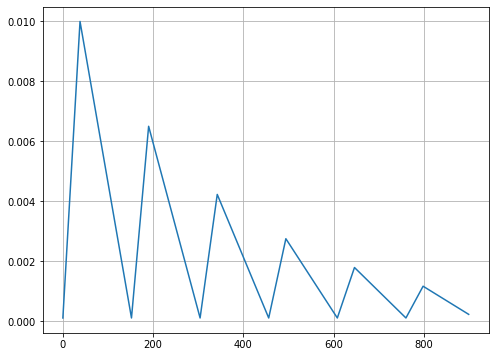

In [18]:
learner.recorder.plot_losses(show_lr=True)

In [19]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(ds_test, loss_fn, model)))

Test loss : 0.24436, test accuracy : 0.907


<br>

### GRU with self attention

In [20]:
class SelfAttention(nn.Module):
    def __init__(self, query_dim, n_outputs, dropout=0.1):
        super().__init__()
        self.W1 = nn.Linear(query_dim, query_dim//2)
        self.W2 = nn.Linear(query_dim//2, n_outputs)
        self.softmax = nn.Softmax(dim=2)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query):
        attn_weights = self.W2(self.dropout(torch.tanh(self.W1(query))))
        attn_weights = attn_weights.permute(0, 2, 1)

        return self.softmax(attn_weights)

In [21]:
class GRU_SelfAttention_model(nn.Module):
    def __init__(self, embed_vecs=None, hidden_size=512, num_layers=1,
                 attn_ouput_size=8, dropout=(0, 0), bidirectional=False):
        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.attn_output_size = attn_ouput_size
        self.embedding = nn.Embedding.from_pretrained(embed_vecs)

        self.gru = nn.GRU(input_size=emb_weights.size()[1], hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout[0],
                          bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(p=dropout[1])
        self.attention = SelfAttention(self.num_directions*self.hidden_size, attn_ouput_size, dropout[0])
        self.head = nn.Linear(self.attn_output_size*self.num_directions*self.hidden_size, 2)

        
    def forward(self, batch):
        batch, lengths = batch
        batch_dim, _ = batch.shape
        
        embedded = self.dropout(self.embedding(batch))
        embedded_packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        outputs_packed, hiddens = self.gru(embedded_packed)
        
        outputs, lengths = nn.utils.rnn.pad_packed_sequence(outputs_packed, batch_first=True)
        
        attn_weights = self.attention(self.dropout(outputs))
        attn_output = torch.bmm(attn_weights, outputs).view(batch_dim, -1)
        
        logging.debug('batch shape : {}'.format(batch.shape))
        logging.debug('embedding shape : {}'.format(embedded.shape))
        logging.debug('hiddens shape : {}'.format(hiddens.shape))
        logging.debug('outputs shape : {}'.format(outputs.shape))
        logging.debug('attn_weights shape : {}'.format(attn_weights.shape))
        logging.debug('attn_output shape : {}'.format(attn_output.shape))
        
        return self.head(self.dropout(attn_output))

In [57]:
model = GRU_SelfAttention_model(emb_weights.clone(), bidirectional=True,
                                num_layers=1, hidden_size=32, attn_ouput_size=8,
                                dropout=(0, 0.5)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = AdamW(model.parameters(), weight_decay=1e-2)
cycle_steps = 2*(len(ds_train)//32 + 1)
scheduler = CyclicLRDecay(optimiser, 1e-4, 1e-2, cycle_steps, 0.25, gamma_factor=0.6)
learner = Learner(model, loss_fn, optimiser, scheduler, ds_train, ds_val, device)

1.00%

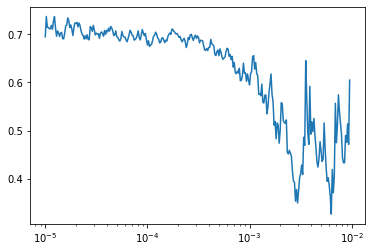

In [25]:
learner.lr_finder(bs=32, lr_range=(1e-5, 1e-2))

In [58]:
learner.train(epochs=8, bs=32, grad_clip=(0.10, 1.2))

06/01/2020 11:47:45 PM INFO : Epoch : 1, batch : 18, train_loss = 0.7043, val_loss = 0.6321, val_accuracy : 0.733, time = 1s
06/01/2020 11:47:46 PM INFO : Epoch : 1, batch : 36, train_loss = 0.5587, val_loss = 0.4877, val_accuracy : 0.803, time = 1s
06/01/2020 11:47:46 PM INFO : Epoch : 1, batch : 54, train_loss = 0.5560, val_loss = 0.5318, val_accuracy : 0.753, time = 2s
06/01/2020 11:47:47 PM INFO : Epoch : 1, batch : 72, train_loss = 0.4745, val_loss = 0.3929, val_accuracy : 0.843, time = 3s
06/01/2020 11:47:48 PM INFO : Epoch : 2, batch : 18, train_loss = 0.3823, val_loss = 0.3360, val_accuracy : 0.847, time = 3s
06/01/2020 11:47:48 PM INFO : Epoch : 2, batch : 36, train_loss = 0.4319, val_loss = 0.3463, val_accuracy : 0.850, time = 4s
06/01/2020 11:47:49 PM INFO : Epoch : 2, batch : 54, train_loss = 0.3496, val_loss = 0.3317, val_accuracy : 0.850, time = 5s
06/01/2020 11:47:49 PM INFO : Epoch : 2, batch : 72, train_loss = 0.4197, val_loss = 0.3045, val_accuracy : 0.877, time = 5s


In [59]:
model.embedding.weight.requires_grad_(True);
learner.train(epochs=4, bs=32, grad_clip=(0.10, 1.2))

06/01/2020 11:48:12 PM INFO : Epoch : 1, batch : 18, train_loss = 0.2799, val_loss = 0.2660, val_accuracy : 0.880, time = 2s
06/01/2020 11:48:13 PM INFO : Epoch : 1, batch : 36, train_loss = 0.2107, val_loss = 0.2635, val_accuracy : 0.883, time = 3s
06/01/2020 11:48:15 PM INFO : Epoch : 1, batch : 54, train_loss = 0.3026, val_loss = 0.2606, val_accuracy : 0.897, time = 5s
06/01/2020 11:48:16 PM INFO : Epoch : 1, batch : 72, train_loss = 0.2859, val_loss = 0.2604, val_accuracy : 0.897, time = 6s
06/01/2020 11:48:18 PM INFO : Epoch : 2, batch : 18, train_loss = 0.2184, val_loss = 0.2586, val_accuracy : 0.893, time = 8s
06/01/2020 11:48:20 PM INFO : Epoch : 2, batch : 36, train_loss = 0.2025, val_loss = 0.2548, val_accuracy : 0.893, time = 9s
06/01/2020 11:48:21 PM INFO : Epoch : 2, batch : 54, train_loss = 0.2028, val_loss = 0.2534, val_accuracy : 0.897, time = 11s
06/01/2020 11:48:23 PM INFO : Epoch : 2, batch : 72, train_loss = 0.2579, val_loss = 0.2528, val_accuracy : 0.883, time = 12

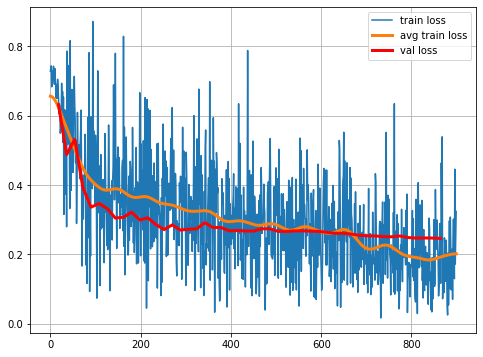

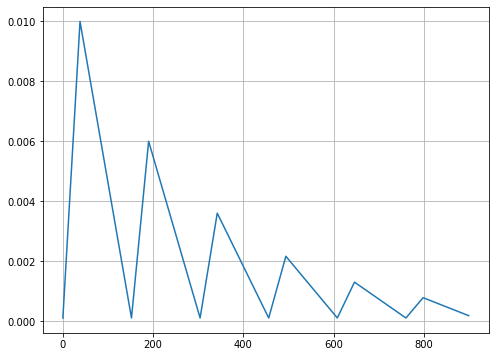

In [60]:
learner.recorder.plot_losses(show_lr=True)

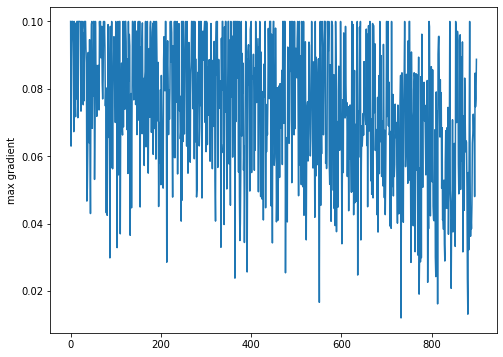

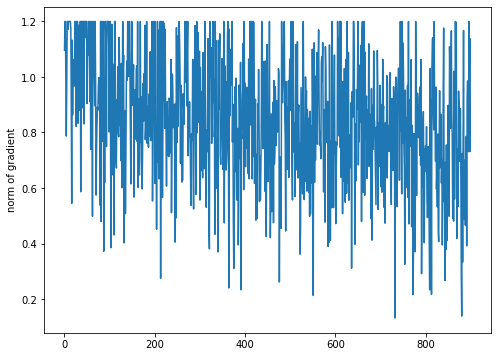

In [61]:
learner.recorder.plot_grads()

In [62]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(ds_test, loss_fn, model)))

Test loss : 0.24100, test accuracy : 0.883


<br>